<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Вывод-по-проделанной-работе" data-toc-modified-id="Вывод-по-проделанной-работе-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод по проделанной работе</a></span></li></ul></div>

# Определение возраста покупателей

**Описание проекта**


Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.



Постройте модель, которая по фотографии определит приблизительный возраст человека.

В вашем распоряжении набор фотографий людей с указанием возраста.


**Инструкция по выполнению проекта**

- Проведите исследовательский анализ набора фотографий.
- Подготовьте данные к обучению.
- Обучите нейронную сеть и рассчитайте её качество.

In [1]:
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,AvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np

## Исследовательский анализ данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


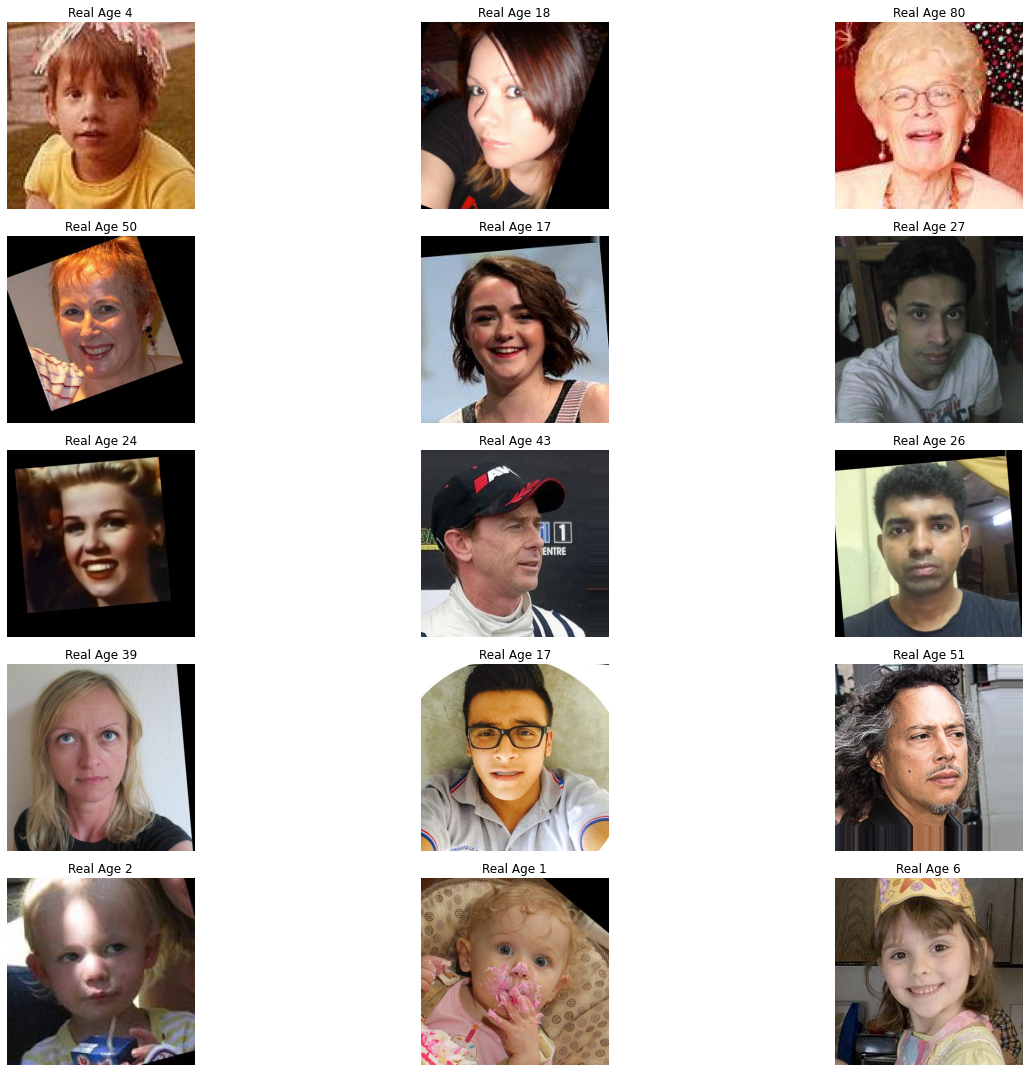

In [3]:
num_rows, num_cols = 5, 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
axes = axes.flatten()

for idx in range(15):
    i = labels.file_name[idx]
    k = labels.real_age[idx]
    image = Image.open('/datasets/faces/final_files/' + i)
    array = np.array(image)
    axes[idx].imshow(array)
    axes[idx].set_title('Real Age {:.0f}'.format(k))
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

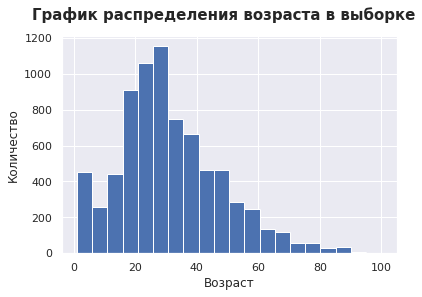

In [4]:
sns.set(style="darkgrid")

plt.hist(labels['real_age'], bins=20) 
plt.xlabel('Возраст') 
plt.ylabel('Количество')
plt.suptitle('График распределения возраста в выборке', fontsize=15, fontweight='bold')
plt.show()

In [5]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [6]:
labels['real_age'].median()

29.0

### Вывод:

- размер выборки: **7591** фотографий

Построен график распределения возраста в выборке: 
- **20-40** лет наиболее часто встречаемый возраст покупателя
- минимальный возраст **1 год**
- максимальный возраст **100 лет**
- средний возраст **31 лет**
- медиана **29 лет**
- график скошен вправо  

На экране напечатано **15** фотографий:


- фотографии цветные
- фотографии имееют разное качество 
- имеются несколько повернутых фотографии


## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1. / 255,
                                       horizontal_flip=True)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=42)


    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1. / 255)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=42)

    return test_datagen_flow


def create_model(input_shape):
    model = Sequential()

    optimizer = Adam(lr=0.0001)

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    backbone.trainable = True

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model 

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/5
2023-05-25 15:23:45.377314: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-25 15:23:45.692802: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 51s - loss: 209.6229 - mae: 10.3930 - val_loss: 792.8337 - val_mae: 23.2286
Epoch 2/5
356/356 - 47s - loss: 83.7996 - mae: 6.9492 - val_loss: 142.7296 - val_mae: 9.3201
Epoch 3/5
356/356 - 47s - loss: 60.4061 - mae: 5.8889 - val_loss: 91.6625 - val_mae: 7.1277
Epoch 4/5
356/356 - 46s - loss: 44.4836 - mae: 5.0861 - val_loss: 72.0529 - val_mae: 6.3344
Epoch 5/5
356/356 - 45s - loss: 33.1019 - mae: 4.4122 - val_loss: 69.8907 - val_mae: 6.2744
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 69.8907 - mae: 6.2744
Test MAE: 6.2744

```

## Анализ обученной модели

Обученна свёрточная нейронная сеть с архитектурой **ResNet50** на датасете с фотографиями людей.



**1.** Модель обучалась на 5 эпохах, динамика следующая:

- c 1 по 4 эпоху показатель метрики **MAE** значительно уменьшалась

- с 4 по 5 эпоху изменение показателя метрики **MAE** не значительно 

**2.** Так-же можно заметить плавное уменьшение **loss**

**3.** Аугментации не приводят к чрезмерным ошибкам и помогают добиться нужного результата

Итоговый показатель метрики **МАЕ** - **6.2744**


По условию задачи, результат **MAE** **<7** можно счтитать отличным.

**Данную модель можно рекомендовать.**

## Вывод по проделанной работе 

**Проведен исследовательский анализ данных:**

- размер выборки: **7591** фотографий

Построен график распределения возраста в выборке: 
- **20-40** лет наиболее часто встречаемый возраст покупателя
- минимальный возраст **1 год**
- максимальный возраст **100 лет**
- средний возраст **31 лет**
- медиана **29 лет**
- график скошен вправо  

На экране напечатано **15** фотографий:


- фотографии цветные
- фотографии имееют разное качество 
- имеются несколько повернутых фотографии


**Была обучена свёрточная нейронная сеть на датасете с фотографиями людей.**

- использованна архитектура **ResNet50.**

- значение **MAE** на тестовой выборке **6.2744**

- написан анализ обученной модели

